In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)

In [2]:
df = pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.describe().style.set_properties(**{"text-align":"center", "padding":"15px"})

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Sprawdzenie udziału poszczególnych kategorii

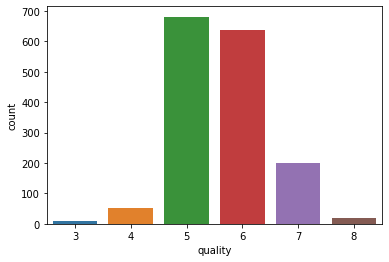

In [6]:
sns.countplot(x=df.quality);

In [7]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

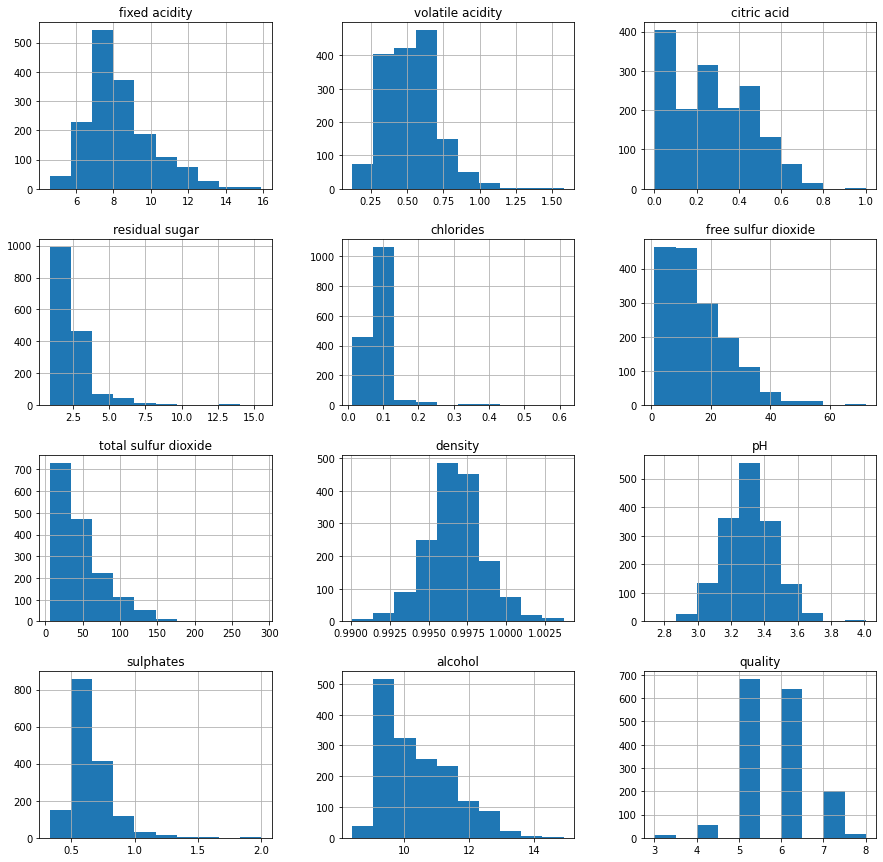

In [8]:
# Histogramy dla wszystkich zmiennych

df.hist(figsize=(15, 15));

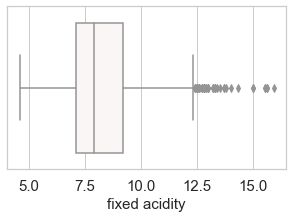

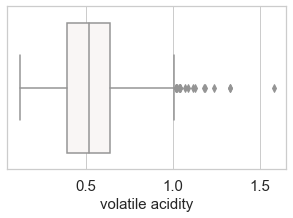

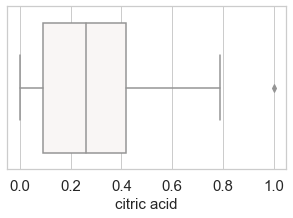

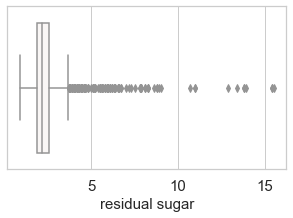

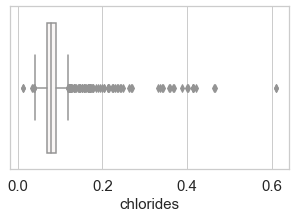

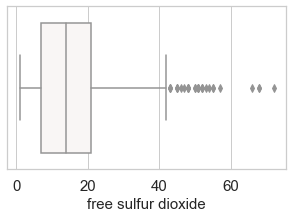

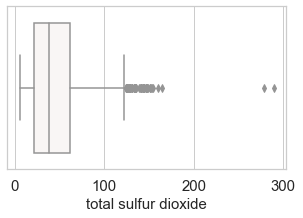

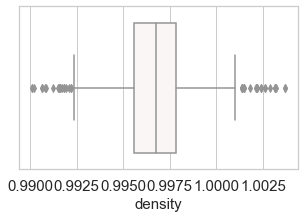

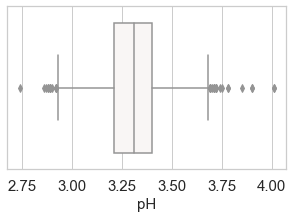

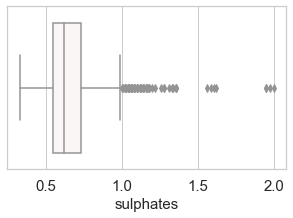

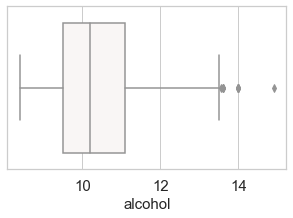

In [9]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop("quality", axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

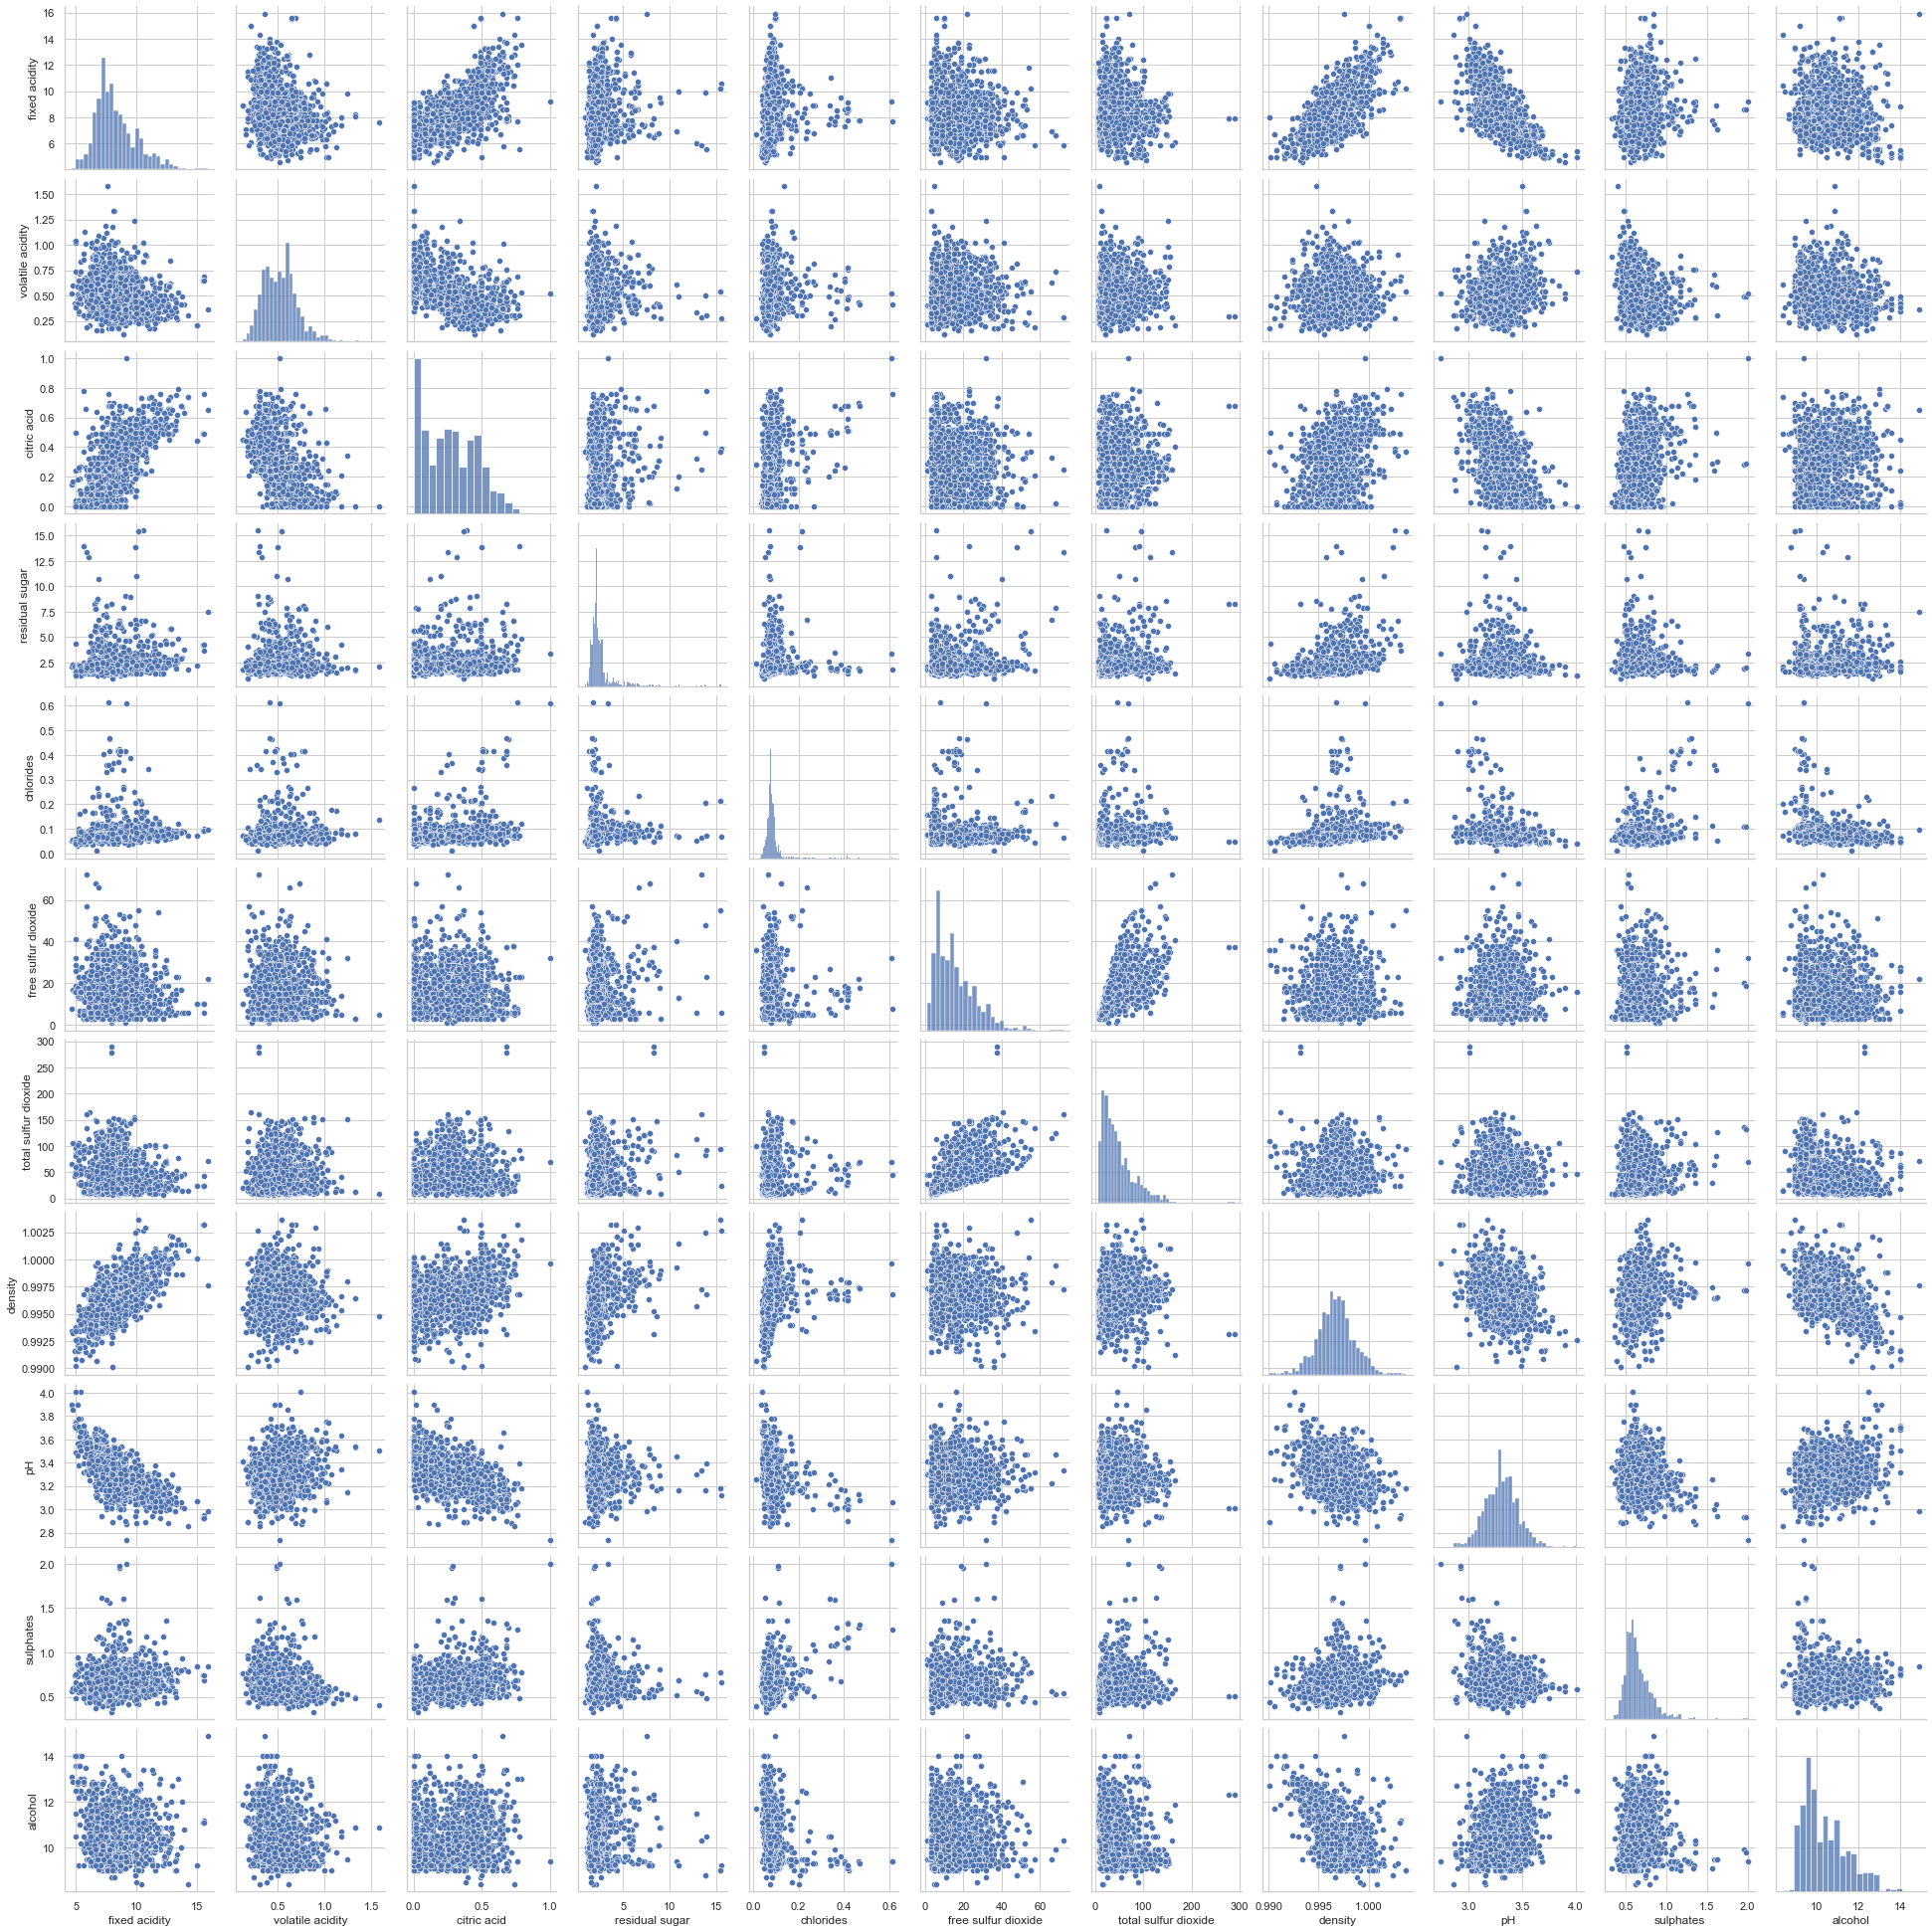

In [10]:
# Korelacje

sns.pairplot(df.drop("quality", axis=1));

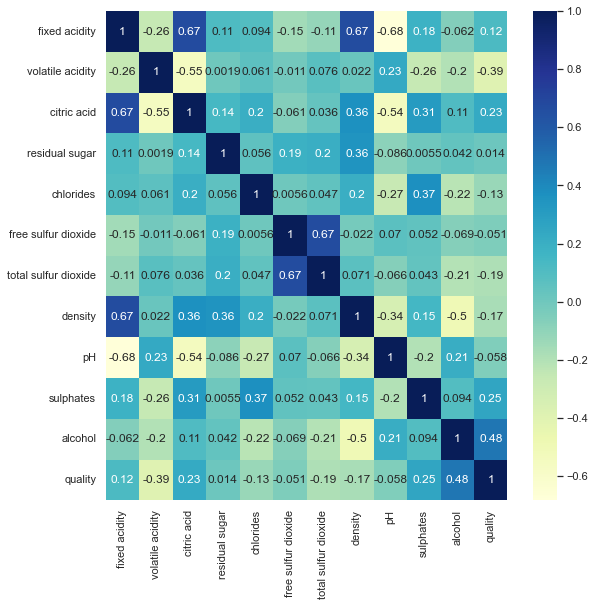

In [11]:
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True);

In [20]:
# # Usuwanie outlier'ów (wartości większych niż 3 odchylenia standardowe) z zestawu danych (konieczne w przypadku KNN i PCA). 

# z_scores = stats.zscore(df)

# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# df_out = df[filtered_entries]

# print("Liczba rekordów przed usunięciem outlier'ów: ", df.shape[0])
# print("Liczba rekordów po usunięciu outlier'ów: ", df_out.shape[0])

Liczba rekordów przed usunięciem outlier'ów:  1599
Liczba rekordów po usunięciu outlier'ów:  1451


In [45]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [15]:
# Podział na zbiór treningowy i testowy

X = df.drop("quality", axis=1)
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)

In [16]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)

print(scaler.mean_, scaler.scale_)

[ 8.30643432  0.52852547  0.27336014  2.56076854  0.08840036 16.11438785
 47.22162645  0.99678033  3.31168007  0.65832887 10.40682157] [1.71323859e+00 1.78561342e-01 1.95152070e-01 1.45967321e+00
 4.99490235e-02 1.02890903e+01 3.30313110e+01 1.90085602e-03
 1.54261600e-01 1.71224301e-01 1.05955405e+00]


In [17]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test)

In [18]:
# Model Random Forest

model_RF = RandomForestClassifier(random_state=1)

model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [19]:
cross_val_score(model_RF, X_train, y_train, cv=10).mean()

C:\Users\doria\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


0.6523970398970398

In [20]:
model_RF.score(X_test, y_test)

0.7104166666666667

In [37]:
model_RF.f1_score(X_test, y_test, average='macro')

AttributeError: 'RandomForestClassifier' object has no attribute 'f1_score'

In [21]:
param_grid_RF_R = {"n_estimators": [10, 17, 25, 33, 41, 48, 56, 64, 72, 80,100,200],
    "ccp_alpha" : [0, 0.2, 0.02],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], 
           "min_samples_split":[3,5,7,9,11,13,15,17,20],
           "bootstrap": [True,False]}
print(param_grid_RF_R)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80, 100, 200], 'ccp_alpha': [0, 0.2, 0.02], 'max_depth': [1, 3, 5, 7, 9, 11, 12], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_features': ['auto', 'log2', 'sqrt', None], 'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90], 'min_samples_split': [3, 5, 7, 9, 11, 13, 15, 17, 20], 'bootstrap': [True, False]}


In [33]:
random_search_RF = RandomizedSearchCV(model_RF,
                                   param_distributions=param_grid_RF_R,
                                   cv=5,
                                   n_iter=500,
                                   verbose=1, scoring='f1_macro')
random_search_RF.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=500,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0, 0.2, 0.02],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [3, 5, 7, 9, 11,
                                                              13, 15, 17, 20],
                                        'min_weight_fraction_l

In [34]:
random_search_RF.best_params_

{'n_estimators': 56,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 60,
 'max_features': None,
 'max_depth': 11,
 'ccp_alpha': 0,
 'bootstrap': True}

In [51]:
param_grid_RF_G = {"n_estimators": [56,100],
            "max_depth" : [11,20],
           "min_samples_leaf":[1,4,7],
           "min_weight_fraction_leaf":[0.0,0.1,0.2],
           "max_leaf_nodes":[None,60,90], 
           "min_samples_split":[3,7],
           "max_features":["auto",None],
           "class_weight": ["balanced",{3:2,8:2}, {3:5,8:5}]}
print(param_grid_RF_G)

{'n_estimators': [56, 100], 'max_depth': [11, 20], 'min_samples_leaf': [1, 4, 7], 'min_weight_fraction_leaf': [0.0, 0.1, 0.2], 'max_leaf_nodes': [None, 60, 90], 'min_samples_split': [3, 7], 'max_features': ['auto', None], 'class_weight': ['balanced', {3: 2, 8: 2}, {3: 5, 8: 5}]}


In [52]:
grid_search_RF = GridSearchCV(model_RF, param_grid=param_grid_RF_G, cv=5, verbose=0,scoring='f1_macro')
grid_search_RF.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'class_weight': ['balanced', {3: 2, 8: 2},
                                          {3: 5, 8: 5}],
                         'max_depth': [11, 20], 'max_features': ['auto', None],
                         'max_leaf_nodes': [None, 60, 90],
                         'min_samples_leaf': [1, 4, 7],
                         'min_samples_split': [3, 7],
                         'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
                         'n_estimators': [56, 100]},
             scoring='f1_macro')

In [53]:
best_param_RF = grid_search_RF.best_index_ 
print('Best params set:', grid_search_RF.best_params_, '(no. {0})'.format(best_param_RF))
print('Best params score:', grid_search_RF.best_score_ )

Best params set: {'class_weight': 'balanced', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 60, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 56} (no. 144)
Best params score: 0.34334080382937693


In [54]:
forest_data_opt = RandomForestClassifier(max_depth = 11, max_leaf_nodes = 60, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=56)
forest_data_opt.fit(X_train, y_train)

# Dokonujemy predykcji dla danych testowych.
y_pred_forest = forest_data_opt.predict(X_test)

# Obliczamy dokładność dla danych testowych
score_RF_opt = accuracy_score(y_test,y_pred_forest)

print('Accuracy (Random Forest):',score_RF_opt)
print('Wynik na zbiorze testowym: ', forest_data_opt.score(X_test, y_test))
print(classification_report(y_test, y_pred_forest))

Accuracy (Random Forest): 0.6770833333333334
Wynik na zbiorze testowym:  0.6770833333333334
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.73      0.80      0.76       204
           6       0.62      0.71      0.66       192
           7       0.71      0.40      0.51        60
           8       0.00      0.00      0.00         5

    accuracy                           0.68       480
   macro avg       0.34      0.32      0.32       480
weighted avg       0.65      0.68      0.65       480



C:\Users\doria\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\doria\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\doria\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
param_grid = {
    "n_estimators": [170, 180, 190, 200],
    "criterion": ["entropy"],
    "max_depth": [20, 25, 30, 35, 40, 50, None],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced"]
             }

grid_search = GridSearchCV(model_RF, param_grid=param_grid, cv=10, verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [20, 25, 30, 35, 40, 50, None],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [170, 180, 190, 200]})

In [69]:
print("Najlepsze parametry: ", grid_search.best_params_)
print("Najwyższy score: ", grid_search.best_score_)

Najlepsze parametry:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 180}
Najwyższy score:  0.6670743544942728


In [71]:
model_RF_best = RandomForestClassifier(random_state=1, **grid_search.best_params_)

model_RF_best.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=25, max_features='sqrt', n_estimators=180,
                       random_state=1)

In [72]:
model_RF_best.feature_importances_

array([0.06291165, 0.13086093, 0.09880334, 0.05668142, 0.08078097,
       0.05925823, 0.08499605, 0.07242675, 0.09245546, 0.13457652,
       0.12624868])

In [73]:
feature_importances = pd.DataFrame(model_RF_best.feature_importances_, index=X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
sulphates,0.134577
volatile acidity,0.130861
alcohol,0.126249
citric acid,0.098803
pH,0.092455
total sulfur dioxide,0.084996
chlorides,0.080781
density,0.072427
fixed acidity,0.062912
free sulfur dioxide,0.059258


In [75]:
y_pred_RF = model_RF_best.predict(X_test)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_RF))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_RF, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0  11   3   0   0]
 [  0 157  28   0   0]
 [  0  47 124   5   0]
 [  0   2  17  37   0]
 [  0   0   2   3   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       1.00      0.00      0.00        14
           5       0.72      0.85      0.78       185
           6       0.71      0.70      0.71       176
           7       0.82      0.66      0.73        56
           8       1.00      0.00      0.00         5

    accuracy                           0.73       436
   macro avg       0.85      0.44      0.44       436
weighted avg       0.74      0.73      0.71       436



In [78]:
# Model KNN

model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train_std, y_train)

KNeighborsClassifier()

In [79]:
cross_val_score(model_KNN, X_train_std, y_train, cv=10).mean()

0.5625897883906038

In [80]:
model_KNN.score(X_test_std, y_test)

0.5940366972477065

In [82]:
y_pred_KNN = model_KNN.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_KNN))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_KNN))

Confusion matrix - tablica pomyłek
 [[  0  10   4   0   0]
 [  2 145  37   1   0]
 [  1  71  90  13   1]
 [  0   6  26  24   0]
 [  0   1   2   2   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       0.00      0.00      0.00        14
           5       0.62      0.78      0.69       185
           6       0.57      0.51      0.54       176
           7       0.60      0.43      0.50        56
           8       0.00      0.00      0.00         5

    accuracy                           0.59       436
   macro avg       0.36      0.34      0.35       436
weighted avg       0.57      0.59      0.58       436



In [88]:
# Dobór optymalnych parametrów dla modelu (ten etap jest powtarzany kilka razy żeby dobrać najlepsze zakresy)

param_grid_KNN = {
            "n_neighbors": list(range(10,30)),
            "weights": ["uniform", "distance"],
            "metric": ["minkowski"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

grid_KNN = GridSearchCV(model_KNN, param_grid=param_grid_KNN, cv=10, verbose=0, n_jobs=-1)
grid_KNN.fit(X_train_std, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski'],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28,
                                         29],
                         'p': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [89]:
print("Najlepsze parametry: ", grid_KNN.best_params_)
print("Najwyższy score: ", grid_KNN.best_score_)

Najlepsze parametry:  {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 19, 'p': 3, 'weights': 'distance'}
Najwyższy score:  0.6659774801009513


In [90]:
# Zastosowanie najlepszych parametrów dla modelu

model_KNN_best = KNeighborsClassifier(**grid_KNN.best_params_)

model_KNN_best.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=19, p=3, weights='distance')

In [91]:
model_KNN_best.score(X_test_std, y_test)

0.7155963302752294

In [93]:
y_pred_KNN2 = model_KNN_best.predict(X_test_std)

print("Confusion matrix - tablica pomyłek\n", confusion_matrix(y_test, y_pred_KNN2))

print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred_KNN2, zero_division=1))

Confusion matrix - tablica pomyłek
 [[  0  11   2   1   0]
 [  0 153  32   0   0]
 [  0  50 121   5   0]
 [  0   1  17  38   0]
 [  0   0   2   3   0]]
Raport klasyfikacyjny: 
               precision    recall  f1-score   support

           4       1.00      0.00      0.00        14
           5       0.71      0.83      0.77       185
           6       0.70      0.69      0.69       176
           7       0.81      0.68      0.74        56
           8       1.00      0.00      0.00         5

    accuracy                           0.72       436
   macro avg       0.84      0.44      0.44       436
weighted avg       0.73      0.72      0.70       436

